## จับบบรรทัด

Lines detected: [(107, 137), (182, 212)]


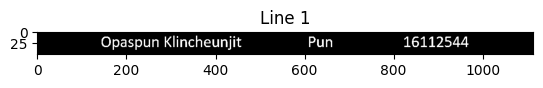

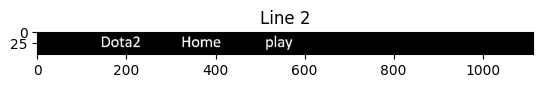

Saved lines to ..\data\output_images\output_lines


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

# โหลดภาพ
#image = cv2.imread("../data/test_images/line_detection/test_a_to_z_3.jpg")
#image = cv2.imread("../data/test_images/line_detection/testAtoZ_1.jpg")
#image = cv2.imread("../data/test_images/line_detection/0to9_2.jpg")
#image = cv2.imread("../data/test_images/transcript/Transcript_page-0001.jpg")
image = cv2.imread("../data/test_images/word_images/word_3.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

# คำนวณ Histogram Projection
horizontal_projection = np.sum(binary_image, axis=1)  # รวมพิกเซลในแนวนอน

threshold_value = 200  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
line_indices = np.where(horizontal_projection > threshold_value)[0]

# แยกช่วงตำแหน่งแต่ละบรรทัด
lines = []
start_idx = None

for i in range(len(line_indices) - 1):
    if start_idx is None:
        start_idx = line_indices[i]
    if line_indices[i+1] > line_indices[i] + 1:  # เจอช่วงว่างระหว่างบรรทัด
        end_idx = line_indices[i]
        lines.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    lines.append((start_idx, line_indices[-1]))

print("Lines detected:", lines)

# แยกบรรทัดและเพิ่ม Padding
line_images = []
padding = 10  # ระบุ Padding

for start, end in lines:
    padded_start = max(0, start - padding)
    padded_end = min(binary_image.shape[0], end + padding)
    line_img = binary_image[padded_start:padded_end, :]
    line_images.append(line_img)

for idx, line_img in enumerate(line_images):
    file_path = output_folder / f"line_{idx + 1}.png"
    cv2.imwrite(str(file_path), line_img)
    plt.figure()
    plt.imshow(line_img, cmap="gray")
    plt.title(f"Line {idx + 1}")
    plt.show()
print(f"Saved lines to {output_folder}")


## จับข้อความในบรรทัด

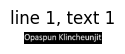

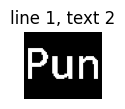

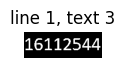

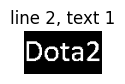

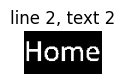

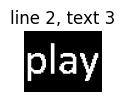

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def histogram_projection(images, distance):
    # คำนวณ Histogram Projection
    horizontal_projection = np.sum(images, axis=0)  # รวมพิกเซลในแนวนอน
    threshold_value = 10  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
    column_indices = np.where(horizontal_projection > threshold_value)[0]

    # แยกช่วงตำแหน่งแต่ละบรรทัด
    columns = []
    start_idx = None

    for i in range(len(column_indices) - 1):
        if start_idx is None:
            start_idx = column_indices[i]
        if column_indices[i + 1] > column_indices[i] + distance:  # เจอช่องว่างระหว่างคอลัมน์
            end_idx = column_indices[i]
            columns.append((start_idx, end_idx))
            start_idx = None
    if start_idx is not None:
        columns.append((start_idx, column_indices[-1]))

    #plt.plot(horizontal_projection)
    #plt.title("Horizontal Projection")
    #plt.show()

    return columns


# แยกข้อความในแต่ละบรรทัด
text_start_end = []
for idx, line_image in enumerate(line_images):
    text_start_end.append(histogram_projection(line_image, 15))

#print(text_start_end)

# แยกคำออกมาจากข้อความ

line_text_groups_images = []
for idx_line, line_img in enumerate(line_images):
    #print("line :", idx_line+1)
    text_images = []
    for idx, text in enumerate(text_start_end[idx_line]):
        start_col = text[0]
        end_col = text[1]
        #print("  text :", idx+1, start_col, end_col)
        word_img = line_img[:, start_col-3:end_col+4]
        text_images.append(word_img)

    line_text_groups_images.append(text_images)

for idx, line in enumerate(line_text_groups_images):
    for idx_text, text in enumerate(line):
        #print(idx_text)
        plt.figure(figsize=(1,1))
        plt.imshow(text, cmap="gray")
        plt.title(f"line {idx + 1}, text {idx_text + 1}")
        plt.axis("off")
        plt.show()




## จับตัวอักษรในข้อความ

Line:2
text:3
char:19
image:31


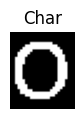

'\nplt.figure(figsize=(1,1))\nplt.imshow(char_image, cmap="gray")\nplt.title(f"Line {idx_line+1}, Text {idx_text+1}, Char {idx_char+1}")\nplt.axis("off")\nplt.show()\n'

In [3]:
def segment_image_horizontal(histogram, image):
    for start_col, end_col in histogram:
        char_img = image[:, start_col-2:end_col+5]
        return char_img
    
def segment_image_horizontal_V2(histogram, image):
    start_col, end_col = histogram[0], histogram[1]
    char_img = image[:, start_col-2:end_col+4]
    return char_img

def contour_image(char_image):

    # หา Contours ในภาพ
    contours, _ = cv2.findContours(char_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # สร้างสำเนาภาพเพื่อวาดกรอบ
    line_with_boxes = cv2.cvtColor(char_image, cv2.COLOR_GRAY2BGR)

    for idx, contour in enumerate(contours):

        # คำนวณกรอบสี่เหลี่ยมรอบ Contour
        x, y, w, h = cv2.boundingRect(contour)

        # เพิ่มขนาดกรอบ 10%
        padding_x = int(w * 0.2)  # เพิ่ม 10% ของความกว้าง
        padding_y = int(h * 0.2)  # เพิ่ม 10% ของความสูง

        # ปรับขอบเขตของกรอบ
        x = max(0, x - padding_x)
        y = max(0, y - padding_y)
        w = min(line_img.shape[1] - x, w + 2 * padding_x)
        h = min(line_img.shape[0] - y, h + 2 * padding_y)

        # กำหนดเงื่อนไขเพื่อกรอง Noise หรือกล่องเล็กเกินไป

        if 2 < w < 100 and 5 < h < 100:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            # ตัดภาพตัวอักษร
            char_img = char_image[y:y+h, x:x+w]

            # วาดกรอบสี่เหลี่ยมในภาพต้นฉบับ
            #cv2.rectangle(line_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)
            #cv2.imwrite(f"../data/output_images/output_characters/char_contours_{idx+1}.jpg", line_with_boxes)
            #cv2.imwrite(f"../data/output_images/output_characters/char_contours_crop_{idx+1}.jpg", char_img)

            return char_img


text_char_group_images = [] #กลุ่มบรรทัดข้อความ
for idx_line, line_text in enumerate(line_text_groups_images):

    text_group_images = [] #กลุ่มข้อความที่มีกลุ่มรูปภาพต่อตัวอักษรอยู่ข้างใน
    for idx_text, text_image in enumerate(line_text):
        char_histogram = histogram_projection(text_image, 1)
        #print(f'line {idx_line+1}, word {idx_text+1}, len {len(char_histogram)}')

        char_group_images = [] #กลุ่มรูปภาพต่อตัวอักษร
        for idx_char, char_his in enumerate(char_histogram):
            char_image = segment_image_horizontal_V2(char_his, text_image)
            char_contour_image = contour_image(char_image)
            char_group_images.append(char_contour_image)

        text_group_images.append(char_group_images)
    
    text_char_group_images.append(text_group_images)

print(f"Line:{len(text_char_group_images)}") #กลุ่มบรรทัด
print(f"text:{len(text_char_group_images[0])}") #กลุ่มข้อความในบรรทัด
print(f"char:{len(text_char_group_images[0][0])}") #กลุ่มตัวอักษรในข้อความ
print(f"image:{len(text_char_group_images[0][0][0])}") #รูปภาพตัวอักษร

plt.figure(figsize=(1,1))
plt.imshow(text_char_group_images[0][0][0], cmap="gray")
plt.title(f"Char")
plt.axis("off")
plt.show()

'''
plt.figure(figsize=(1,1))
plt.imshow(char_image, cmap="gray")
plt.title(f"Line {idx_line+1}, Text {idx_text+1}, Char {idx_char+1}")
plt.axis("off")
plt.show()
'''

## Predict images

1/1 [==============================] - 0s 78ms/step
Character 0: Predicted Label = o (91.48%)
Character 1: Predicted Label = p (100.00%)
Character 2: Predicted Label = a (100.00%)
Character 3: Predicted Label = s (93.47%)
Character 4: Predicted Label = p (100.00%)
Character 5: Predicted Label = u (99.99%)
Character 6: Predicted Label = n (100.00%)
Character 7: Predicted Label = K (100.00%)
Character 8: Predicted Label = I (99.58%)
Character 9: Predicted Label = I (99.58%)
Character 10: Predicted Label = n (100.00%)
Character 11: Predicted Label = c (87.49%)
Character 12: Predicted Label = h (100.00%)
Character 13: Predicted Label = e (100.00%)
Character 14: Predicted Label = u (100.00%)
Character 15: Predicted Label = n (100.00%)
Character 16: Predicted Label = J (86.75%)
Character 17: Predicted Label = I (99.58%)
Character 18: Predicted Label = t (100.00%)


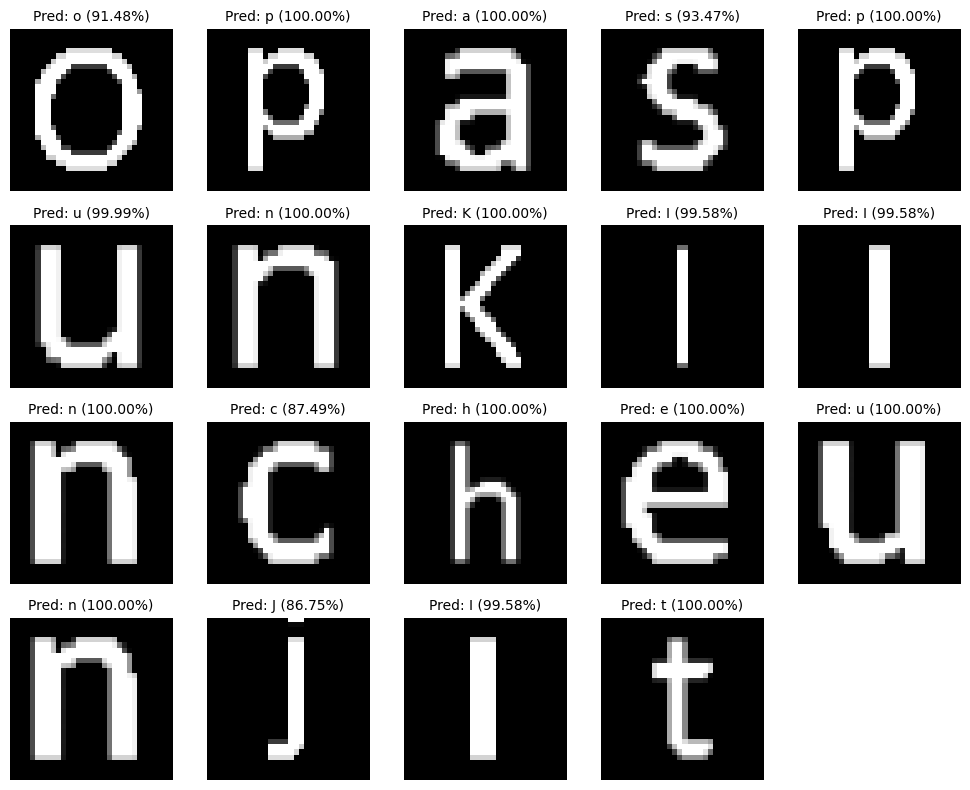

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt

#letter_class = [chr(i) for i in range(ord('0'), ord('9') + 1)]
#letter_class = [chr(i) for i in range(ord('a'), ord('z') + 1)]

# ตัวอักษร 'a-z' และ 'A-Z'
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# สร้างลำดับ a, A, b, B, ...
letters_class = [val for pair in zip(lowercase, uppercase) for val in pair]


def resize_with_aspect_ratio_cv2(image, desired_size):
    """
    ปรับขนาดภาพให้คงสัดส่วนเดิม และเพิ่ม Padding ให้ได้ขนาด desired_size x desired_size
    """
    old_size = image.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)  # อัตราส่วนการปรับขนาด
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding
    delta_w = desired_size - new_size[1]  # Padding ด้านความกว้าง
    delta_h = desired_size - new_size[0]  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # เพิ่ม Padding รอบภาพ
    color = [0]  # สีดำสำหรับ Grayscale
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# โหลดโมเดลที่ฝึกไว้
#model_path = "../models/arabic_numerals_model.h5"
#model_path = "../models/eng_uppercase_model.h5"
#model_path = "../models/eng_lowercase_model.h5"
model_path = "../models/eng_upper_lowercase_model.h5"
model = load_model(model_path)

# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []

for char_img in text_char_group_images[0][0]:

    # เพิ่ม Padding และปรับขนาดภาพ
    padded_img = resize_with_aspect_ratio_cv2(char_img, input_size)
    
    # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
    normalized_img = padded_img / 255.0

    # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
        normalized_img = np.expand_dims(normalized_img, axis=-1)

    # เก็บภาพที่ประมวลผลแล้ว
    processed_images.append(normalized_img)

# แปลงเป็น NumPy Array
processed_images = np.array(processed_images)

# ทำนายผลลัพธ์
predictions = model.predict(processed_images)

# แปลงค่าความน่าจะเป็นเป็นคลาสที่คาดการณ์ได้ และ Confidence Score
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)  # ดึงค่าสูงสุดจากแต่ละแถว (ความมั่นใจของคลาสที่ทำนาย)

# แสดงผลลัพธ์พร้อมภาพ
num_images = len(processed_images)
columns = 5  # จำนวนคอลัมน์ที่ต้องการ
rows = math.ceil(num_images / columns)  # คำนวณจำนวนแถวตามจำนวนภาพ

#plt.figure(figsize=(5, rows * 1))  # ปรับขนาดของกราฟให้รองรับจำนวนแถว
plt.figure(figsize=(columns * 2, rows * 2))  # ขนาดของกราฟสัมพันธ์กับจำนวนแถวและคอลัมน์
for idx, (padded_img, pred_label, confidence) in enumerate(zip(processed_images, predicted_classes, confidence_scores)):
    plt.subplot(rows, columns, idx + 1)  # ปรับ subplot ตามจำนวนแถวและคอลัมน์

    # แปลงภาพกลับเป็น 2D สำหรับการแสดงผล (ในกรณีที่เป็น (height, width, 1))
    if padded_img.shape[-1] == 1:
        padded_img = padded_img.squeeze()
    
    plt.imshow(padded_img, cmap='gray')  # แสดงภาพ Grayscale
    #plt.title(f"Pred: {pred_label + 1}", fontsize=10)  # แสดง Label ที่ทำนาย
    plt.title(f"Pred: {letters_class[pred_label]} ({confidence:.2%})", fontsize=10)  # แสดง Label และ % Confidence
    plt.axis('off')  # ปิดแกน

    print(f"Character {idx}: Predicted Label = {letters_class[pred_label]} ({confidence:.2%})")

plt.tight_layout()  # จัด Layout ให้ชิดกัน
plt.show()



## Predict images V2

In [7]:
model_path = "../models/eng_numerals_model.h5"
model = load_model(model_path)

2/2 [==============================] - 0s 11ms/step
Predicted Letter: o, Confidence: 0.75
Predicted Letter: p, Confidence: 1.00
Predicted Letter: a, Confidence: 1.00
Predicted Letter: s, Confidence: 0.59
Predicted Letter: p, Confidence: 1.00
Predicted Letter: u, Confidence: 1.00
Predicted Letter: n, Confidence: 1.00
Predicted Letter: K, Confidence: 1.00
Predicted Letter: I, Confidence: 1.00
Predicted Letter: I, Confidence: 0.99
Predicted Letter: n, Confidence: 1.00
Predicted Letter: c, Confidence: 0.99
Predicted Letter: h, Confidence: 1.00
Predicted Letter: e, Confidence: 1.00
Predicted Letter: u, Confidence: 1.00
Predicted Letter: n, Confidence: 1.00
Predicted Letter: J, Confidence: 0.78
Predicted Letter: I, Confidence: 0.96
Predicted Letter: t, Confidence: 1.00
Predicted Letter: P, Confidence: 1.00
Predicted Letter: u, Confidence: 1.00
Predicted Letter: n, Confidence: 1.00
Predicted Letter: 1, Confidence: 1.00
Predicted Letter: 6, Confidence: 1.00
Predicted Letter: 1, Confidence: 1.0

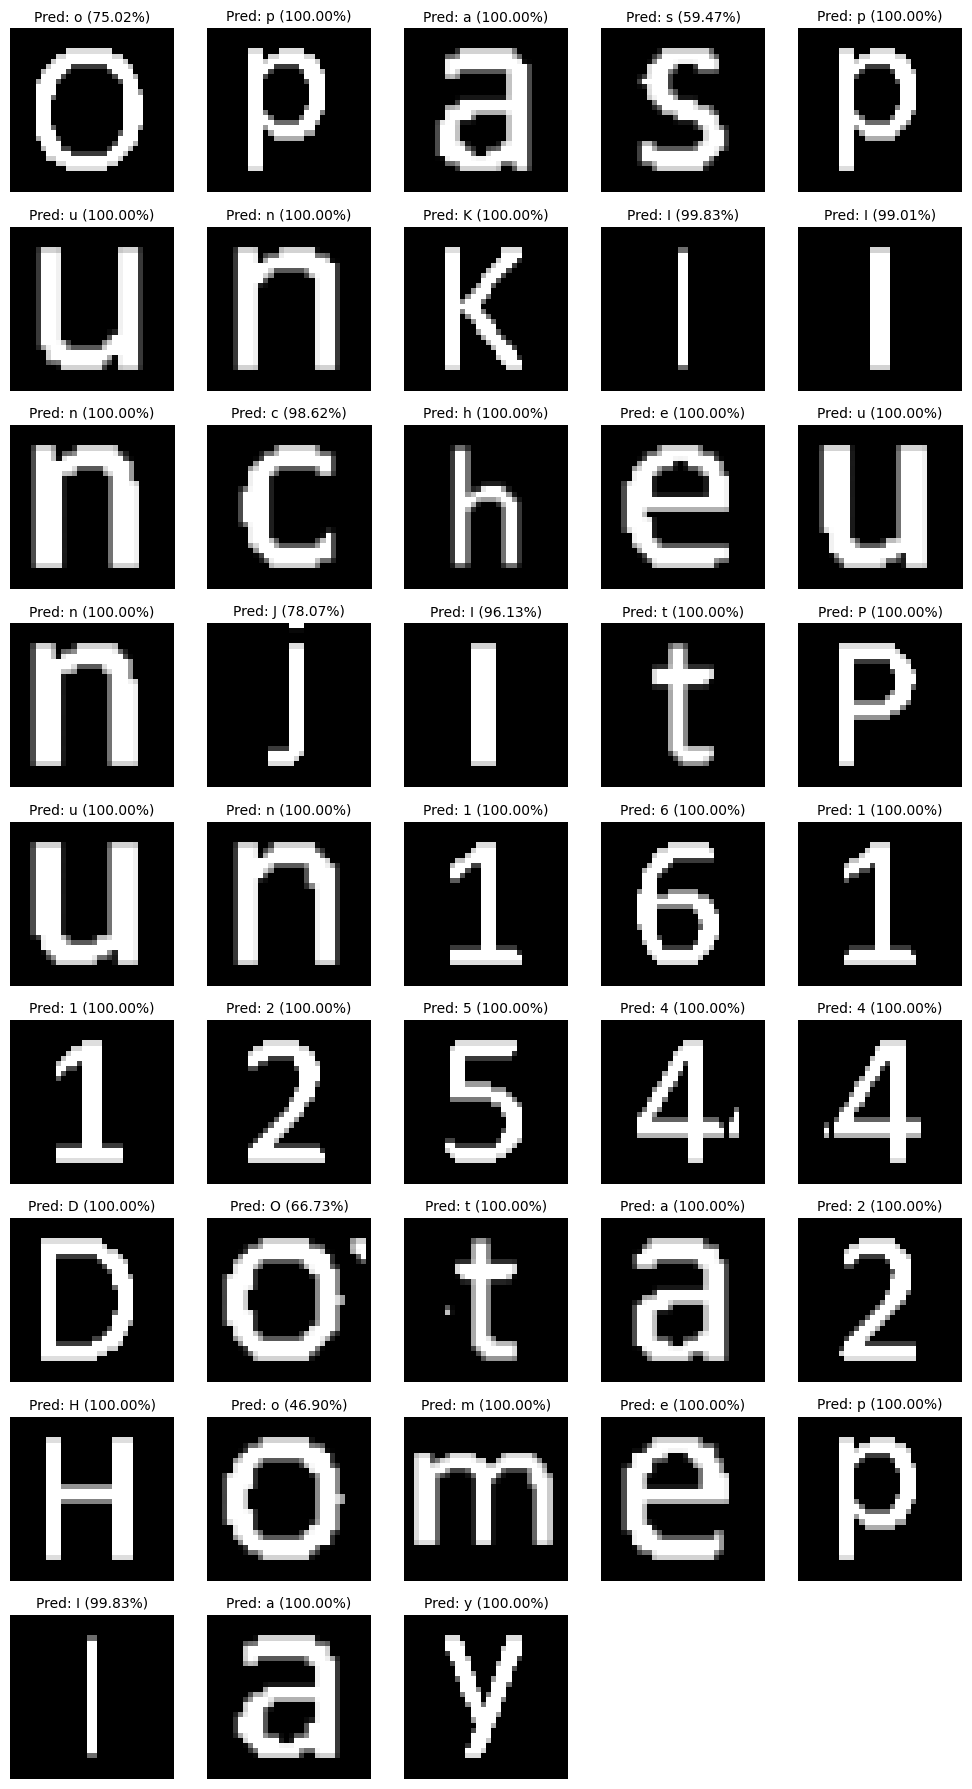

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt

# ตัวเลข 0-9
numbers = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

# ตัวอักษร a-z และ A-Z
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]  # ['a', 'b', ..., 'z']
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # ['A', 'B', ..., 'Z']

# สร้างลำดับ a, A, b, B, ...
letters = [val for pair in zip(lowercase, uppercase) for val in pair]

# รวมตัวเลขและตัวอักษรทั้งหมด
letters_class = numbers + letters

#print(letters_class)
#letters_class = letters_class.extend(["0", "1", "2", "3", "4", "5", "6", "7"])

def resize_with_aspect_ratio_cv2(image, desired_size):
    """
    ปรับขนาดภาพให้คงสัดส่วนเดิม และเพิ่ม Padding ให้ได้ขนาด desired_size x desired_size
    """
    old_size = image.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)  # อัตราส่วนการปรับขนาด
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding
    delta_w = desired_size - new_size[1]  # Padding ด้านความกว้าง
    delta_h = desired_size - new_size[0]  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # เพิ่ม Padding รอบภาพ
    color = [0]  # สีดำสำหรับ Grayscale
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []

text_block = []
for line_text in text_char_group_images:
    for text in line_text:
        for idx, char_img in enumerate(text):
            #plt.figure(figsize=(1,1))
            #plt.imshow(char_img, cmap="gray")

            # เพิ่ม Padding และปรับขนาดภาพ
            padded_img = resize_with_aspect_ratio_cv2(char_img, input_size)

            # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
            normalized_img = padded_img / 255.0

            # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
            if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                normalized_img = np.expand_dims(normalized_img, axis=-1)

            # เก็บภาพที่ประมวลผลแล้ว
            processed_images.append(normalized_img)
    
# แปลงเป็น NumPy Array
processed_images = np.array(processed_images)

# ทำนายผลลัพธ์
predictions = model.predict(processed_images)

# แปลงค่าความน่าจะเป็นเป็นคลาสที่คาดการณ์ได้ และ Confidence Score
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)  # ดึงค่าสูงสุดจากแต่ละแถว (ความมั่นใจของคลาสที่ทำนาย)

for i, pred_class in enumerate(predicted_classes):
    predicted_letter = letters_class[pred_class]  # แปลงคลาสเป็นตัวอักษร
    confidence = confidence_scores[i]  # คะแนนความมั่นใจ
    text_block.append((predicted_letter, confidence))  # เก็บผลลัพธ์

# แสดงผลลัพธ์
for letter, confidence in text_block:
    print(f"Predicted Letter: {letter}, Confidence: {confidence:.2f}")


# แสดงผลลัพธ์พร้อมภาพ
num_images = len(processed_images)
columns = 5  # จำนวนคอลัมน์ที่ต้องการ
rows = math.ceil(num_images / columns)  # คำนวณจำนวนแถวตามจำนวนภาพ

'''
#plt.figure(figsize=(5, rows * 1))  # ปรับขนาดของกราฟให้รองรับจำนวนแถว
plt.figure(figsize=(columns * 2, rows * 2))  # ขนาดของกราฟสัมพันธ์กับจำนวนแถวและคอลัมน์
for idx, (padded_img, pred_label, confidence) in enumerate(zip(processed_images, predicted_classes, confidence_scores)):
    plt.subplot(rows, columns, idx + 1)  # ปรับ subplot ตามจำนวนแถวและคอลัมน์

    # แปลงภาพกลับเป็น 2D สำหรับการแสดงผล (ในกรณีที่เป็น (height, width, 1))
    if padded_img.shape[-1] == 1:
        padded_img = padded_img.squeeze()
    
    plt.imshow(padded_img, cmap='gray')  # แสดงภาพ Grayscale
    #plt.title(f"Pred: {pred_label + 1}", fontsize=10)  # แสดง Label ที่ทำนาย
    plt.title(f"Pred: {letters_class[pred_label]} ({confidence:.2%})", fontsize=10)  # แสดง Label และ % Confidence
    plt.axis('off')  # ปิดแกน

    print(f"Character {idx}: Predicted Label = {letters_class[pred_label]} ({confidence:.2%})")

plt.tight_layout()  # จัด Layout ให้ชิดกัน
plt.show()
'''


